# SPMpy 
* Authors : Dr. Jewook Park at CNMS, ORNL
    * Center for Nanophase Materials Sciences (CNMS), Oak Ridge National Laboratory (ORNL), United States
    * email :  parkj1@ornl.gov
        
> **SPMpy** is a Python package to analyze scanning probe microscopy (SPM) data analysis, such as scanning tunneling microscopy and spectroscopy (STM/S) data and atomic force microscopy (AFM) images, which are inherently multidimensional. SPMpy exploits recent image processing(a.k.a. Computer Vision) techniques and utilizes [building blocks](https://scipy-lectures.org/intro/intro.html#the-scientific-python-ecosystem) and excellent visualization tools available in the [scientific Python ecosystem](https://holoviz.org/index.html). Many parts are inspired by well-known SPM data analysis programs, for example, [Wsxm](http://www.wsxm.eu/) and [Gwyddion](http://gwyddion.net/). SPMpy is trying to apply lessons from [Fundamentals in Data Visualization](https://clauswilke.com/dataviz/).

>  **SPMpy** is an open-source project. (Github: https://github.com/jewook-park/SPMpy_ORNL )
> * Contributions, comments, ideas, and error reports are always welcome. Please use the Github page or email parkj1@ornl.gov. Comments & remarks should be in Korean or English. 

# Create pptx file to summarize 2D SPM dataset 


* use *fileloading_functions* in SPMpy_ORNL
    * **Nanonis** 2D data (*.sxm) files  $\to$  **Xarray** (DataSet or DataArray) (or **PANDAS**  (DataFrame) )
* create pptx file $\to$ add image title & 2D images
    * add image title ( scan condition info & experimental conditions ) 
    * topography + LDOS image(locking dI/dV)
    * generate FFT 
    * save pptx
    


# <font color= orange > 0. Preparation  </font>

In [1]:
#############################
# check all necessary package
#############################

import glob
import os
from warnings import warn

import numpy as np
import pandas as pd

try:
    from ipyfilechooser import FileChooser
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named ipyfilechooser")
    !pip install ipyfilechooser 
    from ipyfilechooser import FileChooser

try:
    import xrft
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named xrft")
    !pip install xrft
    import xrft

In [2]:
########################################
#    * Step 1-1
#    : Import necessary packages
#        import modules
#########################################

import glob
import math
import os
from warnings import warn

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import skimage
from scipy import signal
from SPMpy_2D_data_analysis_funcs import *
from SPMpy_fileloading_functions import (
    grid2xr,
    grid_line2xr,
    gwy_df_ch2xr,
    gwy_img2df,
    img2xr,
)

# some packages may be yet to be installed
try:
    from pptx import Presentation
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named Presentation")
    !pip install python-pptx
    from pptx import Presentation
    from pptx.util import Inches, Pt

try:
    import nanonispy as nap
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named nanonispy")
    !pip install nanonispy
    import nanonispy as nap

try:
    import seaborn_image as isns
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named seaborn-image")
    #!pip install --upgrade scikit-image == 0.19.0.dev0
    !pip install --upgrade seaborn-image
    import seaborn_image as isns

try:
    import xarray as xr
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named xarray")
    #!pip install --upgrade scikit-image == 0.19.0.dev0
    !pip install xarray
    import xarray as xr

try:
    import xrft
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named xrft")
    !pip install xrft
    import xrft
    

try:
    import holoviews as hv
except ModuleNotFoundError:
    warn('ModuleNotFoundError: No module named holoviews')
    !pip install holoviews 
    import holoviews as hv

try:
    import seaborn_image as isns
except ModuleNotFoundError:
    warn('ModuleNotFoundError: No module named seaborn_image')
    !conda install -c conda-forge seaborn-image
    import seaborn_image as isns
    
    
    
try:
    import hvplot.xarray
    import hvplot.pandas 
except ModuleNotFoundError:
    warn('ModuleNotFoundError: No module named hvplot')
    !pip install hvplot
    import hvplot.xarray
    import hvplot.pandas 



try:
    import gwyfile
except ModuleNotFoundError:
    warn('ModuleNotFoundError: No module named gwyfile')
    !pip install gwyfile
    import gwyfile
 

C:\Users\gkp\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# <font color= orange > 1. Choose Folder & DataFrame for files  </font>

In [3]:
###########################################
# Create and display a FileChooser widget #
###########################################
file_chooser = FileChooser("")
display(file_chooser)

FileChooser(path='C:\Users\gkp\OneDrive - Oak Ridge National Laboratory\Research\Data Analysis (python)\SPMpy_…

In [4]:
##############################
# After choose the folder    #
# Files DataFrame            #
##############################

folder_path = file_chooser.selected_path
print("folder_path = ", file_chooser.selected_path)
print("selected file name = ", file_chooser.selected_filename)
from SPMpy_fileloading_functions import files_in_folder

files_df = files_in_folder(folder_path)

folder_path =  C:\Users\gkp\OneDrive - Oak Ridge National Laboratory\mK STM DATA\2023\0521 FeTe0.55Se0.45 (new crystal, batch2) Ni tip5 LHeT_Jewook
selected file name =  Bias-Spectroscopy(x1_f1)_000001.dat
Current Path =  C:\Users\gkp\OneDrive - Oak Ridge National Laboratory\Research\Data Analysis (python)\SPMpy_ORNL
Changed Path =  C:\Users\gkp\OneDrive - Oak Ridge National Laboratory\mK STM DATA\2023\0521 FeTe0.55Se0.45 (new crystal, batch2) Ni tip5 LHeT_Jewook
                                                group  num  \
0          FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00  001   
1          FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00  002   
2          FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00  003   
3   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  001   
4   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  002   
5   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  003   
6   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  004   
7   FeTe0.45Se0.55_Nitip5_LHeT_(x0.0

# <font color= orange > 2. loading files & data import    </font>

In [5]:
#######

files_df

sxm_file_list_df = files_df[files_df.type == "sxm"]
# file_list_df

# use sxm file list only 
sxm_file_groups = list(set(sxm_file_list_df["group"]))
# file groups
sxm_file_groups
#############################
# sxm file loading by using img2xr
#  convert to xr format
# (e.g.) # img2xr(file_list_df.file_name.iloc[0])
#############################
# spmdata_xr = img2xr(file_list_df.file_name[0])

['FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230523_00',
 'FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230521_00',
 'FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00',
 'FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230522_00']

# <font color= orange > 3. Creating PPTX file </font>

In [6]:
###############################
# new pptx file 
# overwrite everytime 
###############################

folder_name  = os.getcwd().split('\\')[-1]
# final folder 
pptx_file_name =  folder_name+ '_automated.pptx'

prs = Presentation() # empty_file #
#``` Page 0 ``````````
sld0_slide_layout = prs.slide_layouts[0] # title slide (layout_type =  [0] )

slide0 = prs.slides.add_slide(sld0_slide_layout)
# add title slide in the pptx file # 

# title page set up 
sld0_title = slide0.shapes.title
sld0_subtitle = slide0.placeholders[1]
# title & sub_title for the title slide (0th) 
 
sld0_title.text = 'Nanonois 2D images' + '\n' +  'in '+ folder_name 
# set title 
sld0_subtitle.text = 'by using SPMpy \n  Jewook Park '

#``` Page 1 ``````````

sld1_slide_layout = prs.slide_layouts[1] # bullet_slide # title+content
slide1 = prs.slides.add_slide(sld1_slide_layout)
#add page  1 slide
slide1_title  = slide1.shapes.title
slide1_contents  = slide1.shapes.placeholders[1].text_frame
# choose 'shapes' in 'slide1' 
# assigne 'title' & 'contents(text)'  in 'shapes' 

slide1_title.text = 'file list (*.sxm)' # set title
slide1_contents.text = 'file groups' # set contents
# add 'text' in the 'title'  object 

for group in sxm_file_groups:
    sld1_paragraph_1 = slide1_contents.add_paragraph()
    sld1_paragraph_1.text = group
    sld1_paragraph_1.level = 2   
    # add paragraph in the contents  : group name
    sld1_paragraph_1 = slide1_contents.add_paragraph()
    sld1_paragraph_1.text = files_df[files_df.group ==  group].file_name.min() + '\n ~ ' + files_df[files_df.group ==  group].file_name.max()
    sld1_paragraph_1.level = 3    
    # add paragraph in the contents  : Files (start-end) name
prs.save(pptx_file_name)  

# add group_name & number of files as a paragraph




# <font color= orange > 4. add data page </font>

scan direction (up/down):  up
FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00001
20 nm x 20 nm  V = 1.0 V  I = 100 pA 
['LI_Demod_1_X']
dim_px != dim_py
step_dx/step_dy =  2.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 512, 'X': 512"]
sample type will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


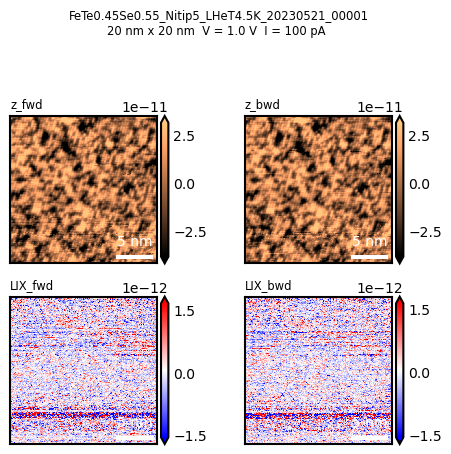

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


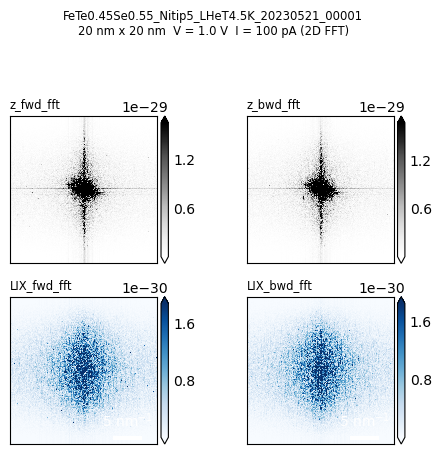

scan direction (up/down):  up
FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00002
400 nm x 400 nm  V = 0.2 V  I = 100 pA 
['LI_Demod_1_X']
dim_px != dim_py
step_dx/step_dy =  8.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
sample type will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


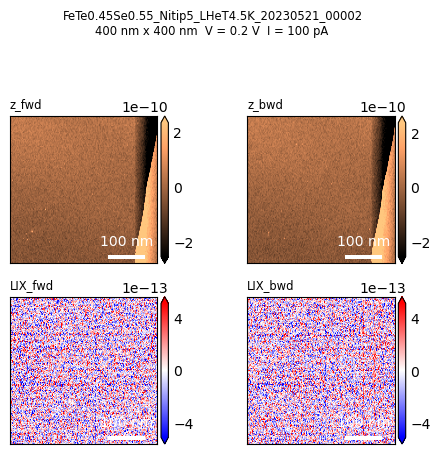

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


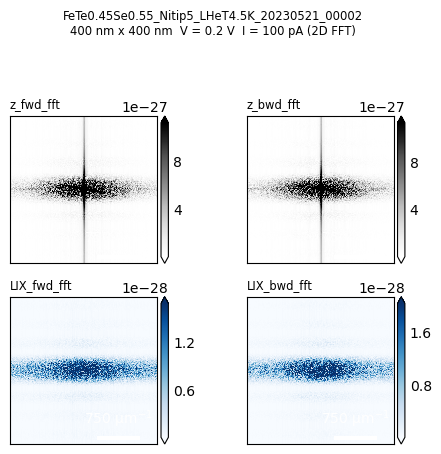

scan direction (up/down):  up
FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00003
160 nm x 160 nm  V = 0.1 V  I = 100 pA 
['LI_Demod_1_X']
dim_px != dim_py
step_dx/step_dy =  4.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
sample type will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


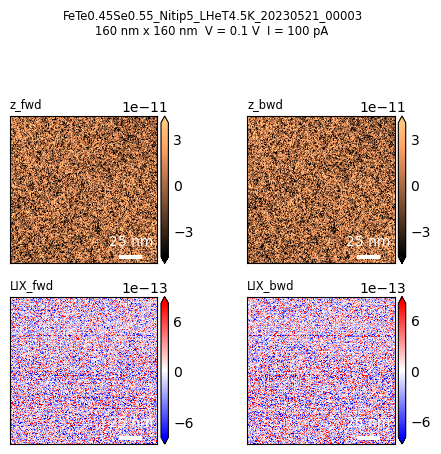

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


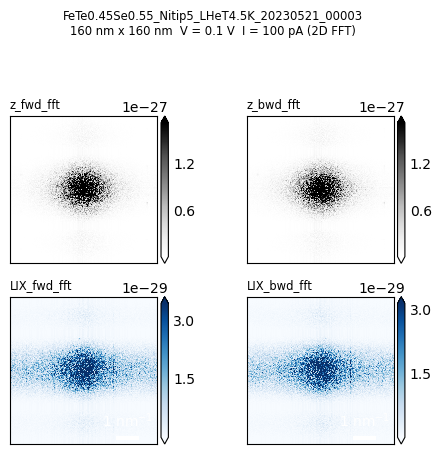

scan direction (up/down):  up
FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230521_00001
80 nm x 80 nm  V = 0.01 V  I = 200 pA 
['LI_Demod_1_X']
dim_px != dim_py
step_dx/step_dy =  2.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
sample type will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


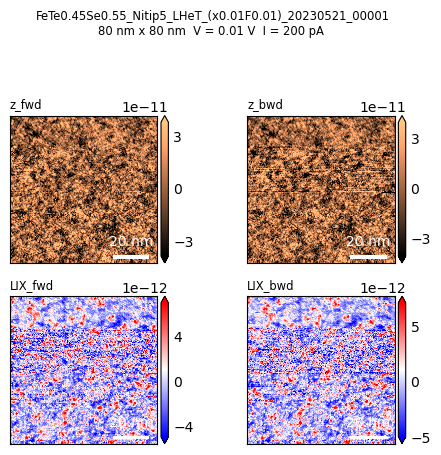

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


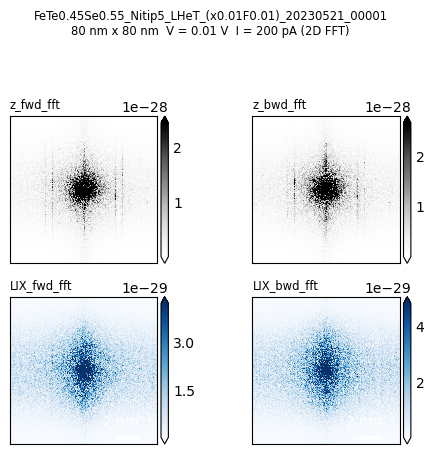

scan direction (up/down):  up
FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230521_00002
32 nm x 32 nm  V = -0.01 V  I = 200 pA 
['LI_Demod_1_X']
dim_px != dim_py
step_dx/step_dy =  2.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
sample type will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


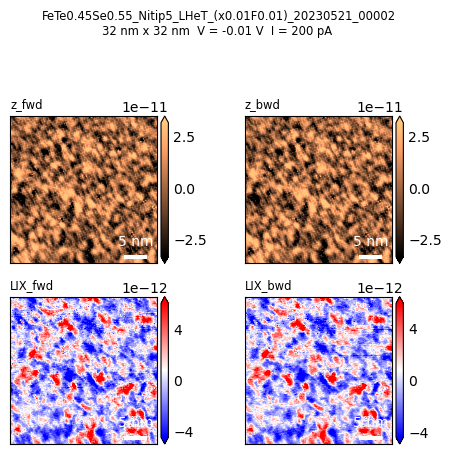

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


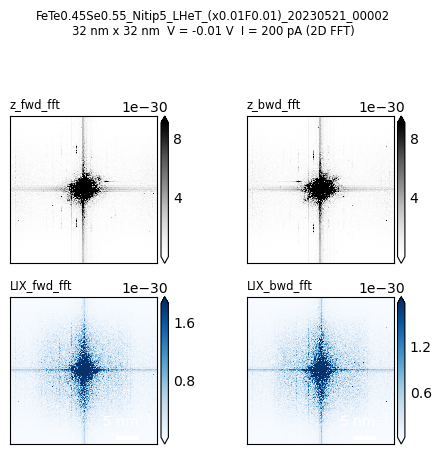

scan direction (up/down):  up
FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230521_00003
32 nm x 32 nm  V = 0.006 V  I = 200 pA 
['LI_Demod_1_X']
step_dx == step_dy
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
sample type will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


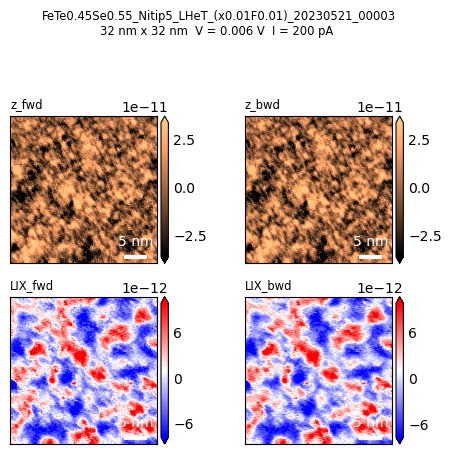

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


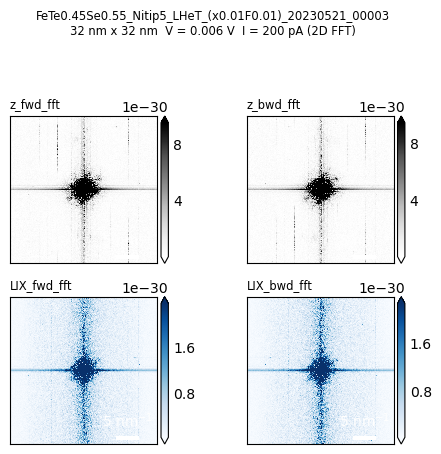

scan direction (up/down):  up
FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230521_00004
20 nm x 20 nm  V = 0.006 V  I = 200 pA 
['LI_Demod_1_X']
step_dx == step_dy
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 512, 'X': 512"]
sample type will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


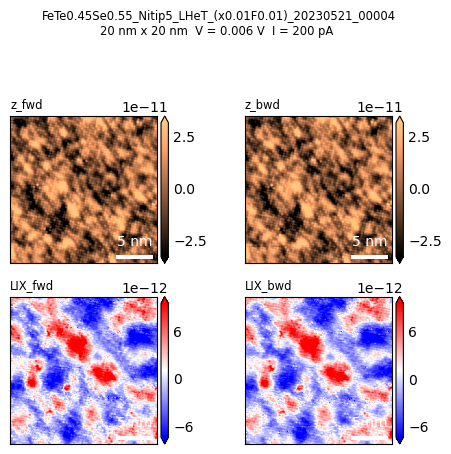

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


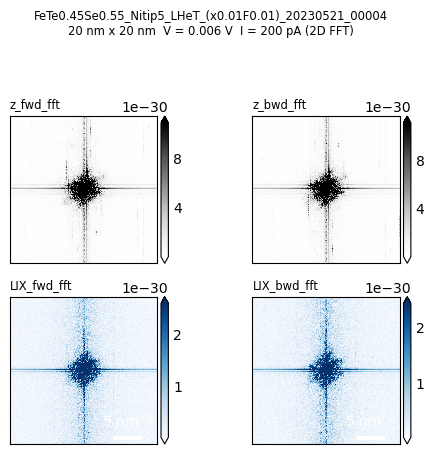

scan direction (up/down):  up
FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230522_00001
20 nm x 20 nm  V = 0.006 V  I = 200 pA 
['LI_Demod_1_X']
step_dx == step_dy
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 512, 'X': 512"]
sample type will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


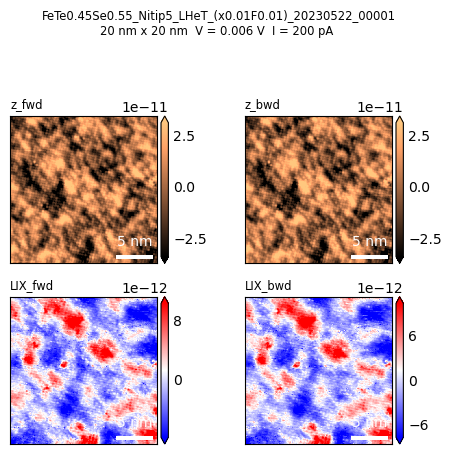

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


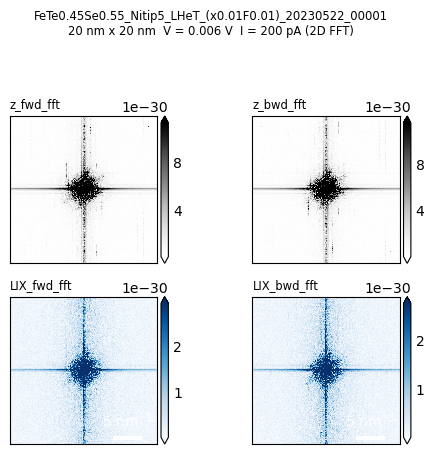

scan direction (up/down):  up
FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230522_00002
80 nm x 80 nm  V = -0.006 V  I = 200 pA 
['LI_Demod_1_X']
dim_px != dim_py
step_dx/step_dy =  2.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
sample type will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


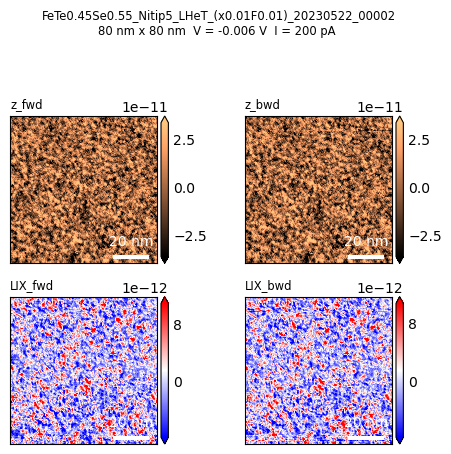

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


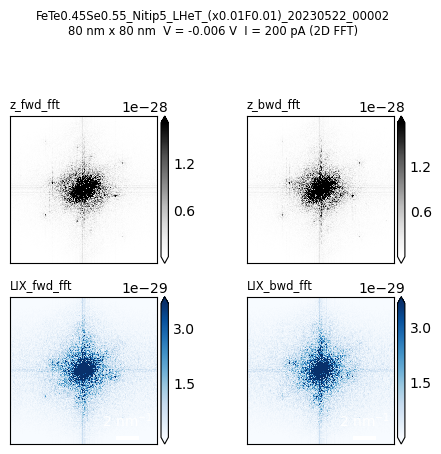

scan direction (up/down):  up
FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230522_00003
80 nm x 80 nm  V = 0.006 V  I = 200 pA 
['LI_Demod_1_X']
dim_px != dim_py
step_dx/step_dy =  2.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
sample type will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


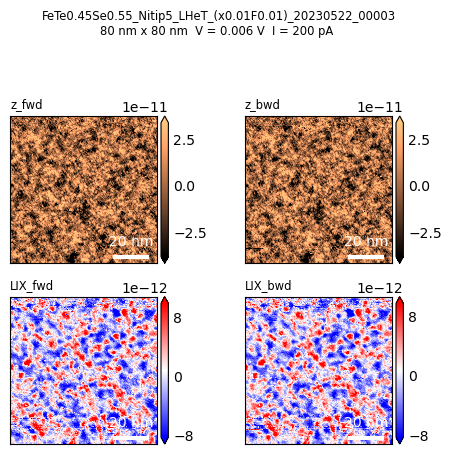

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


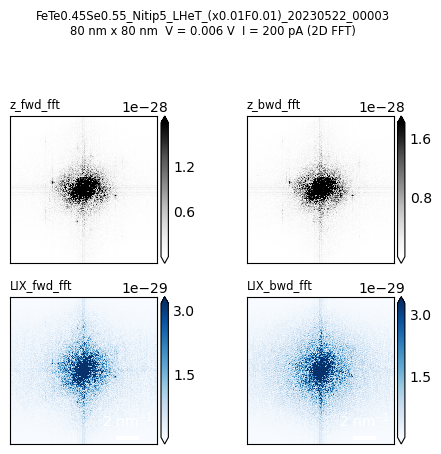

scan direction (up/down):  up
multipass detected
FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230522_00004
80 nm x 80 nm  V = 0.003 V  I = 200 pA 
Pass1 fwd @3.0 mV/ Pass1 bwd @3.0 mV// Pass2 fwd @-3.0 mV/ Pass2 bwd @-3.0 mV
dim_px != dim_py
step_dx/step_dy =  2.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
sample type will be announced
Z_fwd_isns
Z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


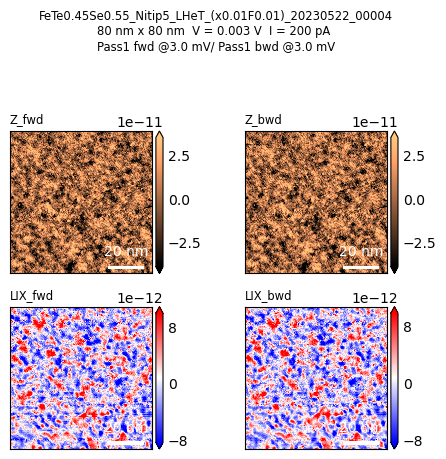

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
Z_fwd_fft_isns
Z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


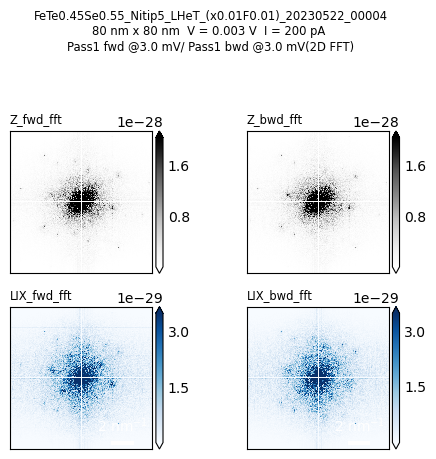

Z_fwd_isns
Z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


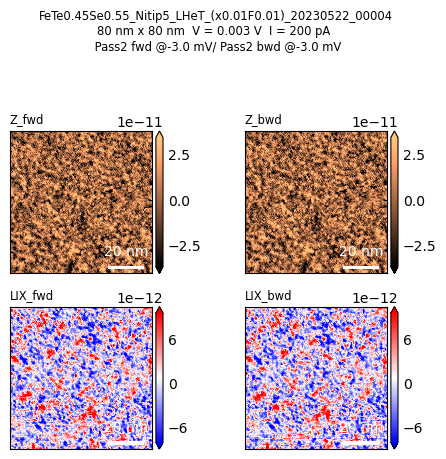

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
Z_fwd_fft_isns
Z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


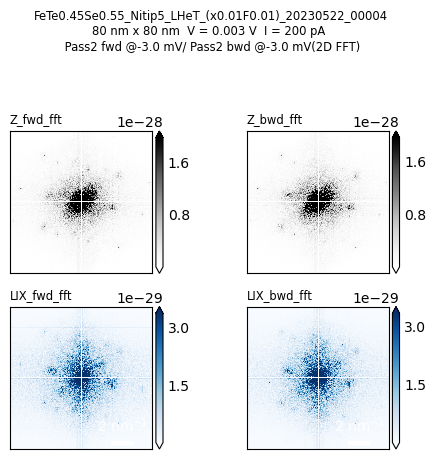

scan direction (up/down):  up
FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_20230523_00001
80 nm x 80 nm  V = -0.01 V  I = 200 pA 
['LI_Demod_1_X']
step_dx == step_dy
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 512, 'X': 512"]
sample type will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


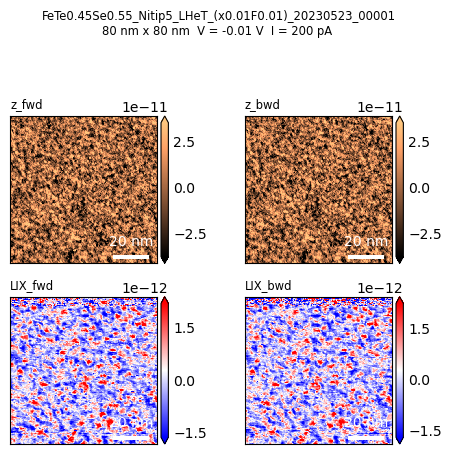

complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
complex128 after fft
complex128 after fft+ np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


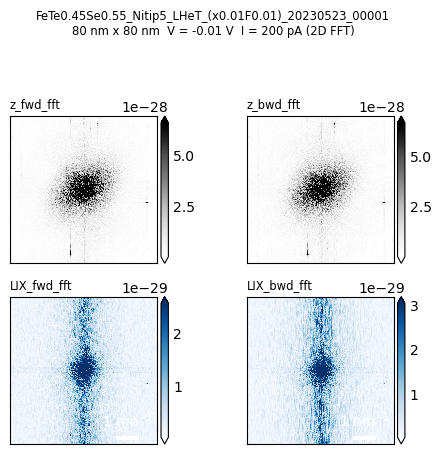

In [7]:
#from pptx import Presentation
from pptx.util import Inches
from pptx.util import Cm, Pt

for files_name in files_df[files_df.type ==  'sxm'].file_name:
    spmdata_xr = img2xr(files_name)

    # open previously prepared pptx 
    prs = Presentation(pptx_file_name)

    if spmdata_xr.multipass == True :
        # split spmdata_xr as  spmdata_P1_xr & spmdata_P2_xr
        # 
        spmdata_P1_xr = spmdata_xr.drop(['Z_P2fwd', 'Z_P2bwd','LIX_P2fwd', 'LIX_P2bwd'])
        spmdata_P2_xr = spmdata_xr.drop(['Z_P1fwd', 'Z_P1bwd','LIX_P1fwd', 'LIX_P1bwd'])

        # rename channel names after split dual XR 

        spmdata_P1_xr = spmdata_P1_xr.rename ({'Z_P1fwd': 'Z_fwd', 'Z_P1bwd': 'Z_bwd', 'LIX_P1fwd': 'LIX_fwd', 'LIX_P1bwd': 'LIX_bwd'})
        spmdata_P2_xr = spmdata_P2_xr.rename ({'Z_P2fwd': 'Z_fwd', 'Z_P2bwd': 'Z_bwd', 'LIX_P2fwd': 'LIX_fwd', 'LIX_P2bwd': 'LIX_bwd'})
        
        # set P1 P2 title
        
        spmdata_P1_xr.attrs['title'] =  spmdata_P1_xr.title.split('//')[0]
        spmdata_P2_xr.attrs['title'] = spmdata_P2_xr.title.split('Pass1')[0]+spmdata_P2_xr.title.split('//')[-1]
        
        
        ###########################
        # P1 page setting 
        
        img_sld_slide_layout = prs.slide_layouts[6] # image slide (layout_type =  [6] )
        img_sld = prs.slides.add_slide(img_sld_slide_layout)
        # textbox setting
        left_textbox = Inches(0)
        top_textbox = Inches(0)
        width_textbox = Inches(4)
        height_textbox = Inches(1)
        txBox  = img_sld.shapes.add_textbox(left_textbox, top_textbox,width_textbox,height_textbox )

        tx_frame = txBox.text_frame 
        tx_frame.text =  spmdata_xr.title

        # real space figure 
        left = Inches(0)
        top = Inches(1)

        spm_data_plot = xr_isns_plot_r_space(plane_fit_x_xr(plane_fit_y_xr(spmdata_P1_xr)),
                                             figsize= (5,6))
        spm_data_plot.savefig('spm_data_plot_temp1.png', 
                              bbox_inches='tight', dpi = 300)

        r_space_img = img_sld.shapes.add_picture('spm_data_plot_temp1.png', 
                                               left, 
                                               top)
        # momentum space figure
        spm_data_fft_plot = xr_isns_plot_k_space(twoD_FFT_xr( plane_fit_x_xr(plane_fit_y_xr(spmdata_P1_xr))), 
                                                 figsize= (5,6),
                                                 zoom_in_fft= False, zoom_in_expand= False)

        spm_data_fft_plot.savefig('spm_data_fft_plot_temp1.png',bbox_inches='tight', dpi = 300)
        left_2 = Inches(5)

        k_space_img = img_sld.shapes.add_picture('spm_data_fft_plot_temp1.png',
                                               left_2,
                                               top)
    
    
        ###################################
        ### P2 page setting 
        
        img_sld_slide_layout = prs.slide_layouts[6] # image slide (layout_type =  [6] )
        img_sld = prs.slides.add_slide(img_sld_slide_layout)
        # textbox setting
        left_textbox = Inches(0)
        top_textbox = Inches(0)
        width_textbox = Inches(4)
        height_textbox = Inches(1)
        txBox  = img_sld.shapes.add_textbox(left_textbox, top_textbox,width_textbox,height_textbox )

        tx_frame = txBox.text_frame 
        tx_frame.text =  spmdata_xr.title

        # real space figure 
        left = Inches(0)
        top = Inches(1)

        spm_data_plot = xr_isns_plot_r_space(plane_fit_x_xr(plane_fit_y_xr(spmdata_P2_xr)),
                                             figsize= (5,6))
        spm_data_plot.savefig('spm_data_plot_temp2.png', 
                              bbox_inches='tight', dpi = 300)

        r_space_img = img_sld.shapes.add_picture('spm_data_plot_temp2.png', 
                                               left, 
                                               top)
        # momentum space figure
        spm_data_fft_plot = xr_isns_plot_k_space(twoD_FFT_xr( plane_fit_x_xr(plane_fit_y_xr(spmdata_P2_xr))), 
                                                 figsize= (5,6),
                                                 zoom_in_fft= False, zoom_in_expand= False)

        spm_data_fft_plot.savefig('spm_data_fft_plot_temp2.png',bbox_inches='tight', dpi = 300)
        left_2 = Inches(5)

        k_space_img = img_sld.shapes.add_picture('spm_data_fft_plot_temp2.png',
                                               left_2,
                                               top)
    
        
    
    else : 

        img_sld_slide_layout = prs.slide_layouts[6] # image slide (layout_type =  [6] )
        img_sld = prs.slides.add_slide(img_sld_slide_layout)
        # textbox setting
        left_textbox = Inches(0)
        top_textbox = Inches(0)
        width_textbox = Inches(4)
        height_textbox = Inches(1)
        txBox  = img_sld.shapes.add_textbox(left_textbox, top_textbox,width_textbox,height_textbox )

        tx_frame = txBox.text_frame 
        tx_frame.text =  spmdata_xr.title

        # real space figure 
        left = Inches(0)
        top = Inches(1)

        spm_data_plot = xr_isns_plot_r_space(plane_fit_x_xr(plane_fit_y_xr(spmdata_xr)),
                                             figsize= (5,6))
        spm_data_plot.savefig('spm_data_plot_temp.png', 
                              bbox_inches='tight', dpi = 300)

        r_space_img = img_sld.shapes.add_picture('spm_data_plot_temp.png', 
                                               left, 
                                               top)
        # momentum space figure
        spm_data_fft_plot = xr_isns_plot_k_space(twoD_FFT_xr( plane_fit_x_xr(plane_fit_y_xr(spmdata_xr))), 
                                                 figsize= (5,6),
                                                 zoom_in_fft= False, zoom_in_expand= False)

        spm_data_fft_plot.savefig('spm_data_fft_plot_temp.png',bbox_inches='tight', dpi = 300)
        left_2 = Inches(5)

        k_space_img = img_sld.shapes.add_picture('spm_data_fft_plot_temp.png',
                                               left_2,
                                               top)
    prs.save(pptx_file_name)  


#pptx page 

In [8]:
files_df

group  num  \
0          FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00  001   
1          FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00  002   
2          FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00  003   
3   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  001   
4   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  002   
5   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  003   
6   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  004   
7   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  001   
8   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  002   
9   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  003   
10  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  004   
11  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  001   
12            Grid_line_Spectroscopy_(x0.01)after0003  001   
13                 Grid_Spectroscopy_(x0.01)after0004  001   
14                 Grid_Spectroscopy_(x0.01)after0004  002   
15      FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00001  NaN   
16      FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00002  NaN   
17      FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00003  NaN   
18  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  NaN   
19  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  NaN   
20  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  NaN   
21  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  NaN   
22  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  NaN   
23  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  NaN   
24  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  NaN   
25  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  NaN   
26  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  NaN   
27  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...  NaN   
28                          approach Ni tip 2023 0521  NaN   
29                            lattice constant check_  NaN   

                                            file_name  type  
0   FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00001.sxm   sxm  
1   FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00002.sxm   sxm  
2   FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00003.sxm   sxm  
3   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   sxm  
4   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   sxm  
5   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   sxm  
6   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   sxm  
7   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   sxm  
8   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   sxm  
9   FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   sxm  
10  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   sxm  
11  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   sxm  
12     Grid_line_Spectroscopy_(x0.01)after0003001.3ds   3ds  
13          Grid_Spectroscopy_(x0.01)after0004001.3ds   3ds  
14          Grid_Spectroscopy_(x0.01)after0004002.3ds   3ds  
15  FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00001.gwy   gwy  
16  FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00002.gwy   gwy  
17  FeTe0.45Se0.55_Nitip5_LHeT4.5K_20230521_00003.gwy   gwy  
18  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   gwy  
19  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   gwy  
20  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   gwy  
21  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   gwy  
22  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   gwy  
23  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   gwy  
24  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   gwy  
25  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   gwy  
26  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   gwy  
27  FeTe0.45Se0.55_Nitip5_LHeT_(x0.01F0.01)_202305...   gwy  
28                     approach Ni tip 2023 0521.xlsx  xlsx  
29                       lattice constant check_.xlsx  xlsx